# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
import numpy as np
from keras import regularizers
from tensorflow.keras.layers import Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd


seed=12345



In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator()

In [4]:
datagen_flow = datagen.flow_from_directory(
    '/datasets/faces/',
    target_size=(150, 150), 
    batch_size=16,
    class_mode='sparse',
    seed=seed)

Found 7591 images belonging to 1 classes.


In [5]:
datagen_flow

In [6]:
datagen_flow.class_indices

{'final_files': 0}

In [7]:
data.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


<AxesSubplot:>

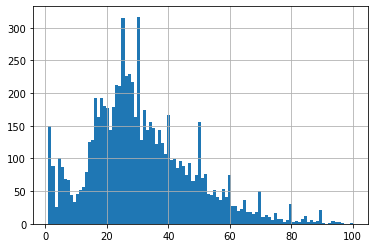

In [9]:
data['real_age'].hist(bins = 100)

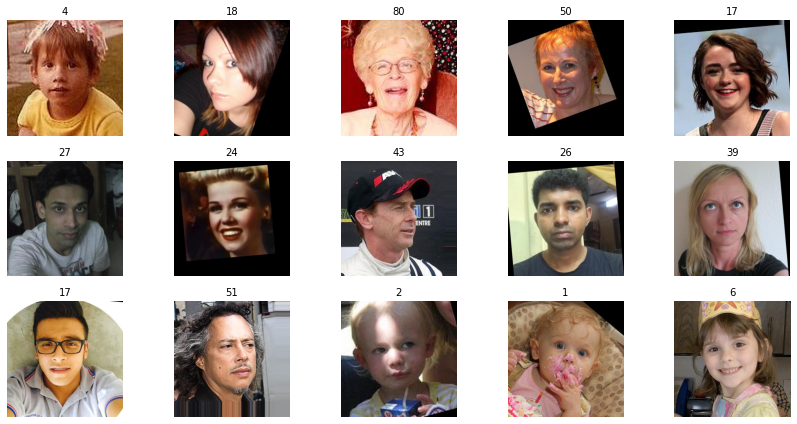

In [12]:
plt.figure(figsize=(12, 6))  

for i in range(15):
    file_name = data.loc[i, 'file_name']
    age = data.loc[i, 'real_age']  # Получаем возраст
    image = Image.open('/datasets/faces/final_files/' + file_name)
    
    plt.subplot(3, 5, i + 1)  
    plt.imshow(np.array(image))
    plt.axis('off')
    plt.title(f'{int(age)}', fontsize=10)  # Подпись с возрастом

plt.tight_layout()
plt.show()

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Для оценки адекватности разметки возрастов было б неплохо подписать изображения указанным возрастом человека на фото

<div class="alert alert-info"> <b>🎓 Комментарий студента:</b> 
Да, конечно, давай на "ты". Приятно познакомиться. 
</div>

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера v2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Вроде уже познакомились 😁

Здорово, что обращаешь внимание не только на красные комментарии :)

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):

    df = pd.read_csv(f'{path}/labels.csv')
    
    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=90,
        width_shift_range=0.2
    )

    train_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_generator
  
def load_test(path):
    df = pd.read_csv(f'{path}/labels.csv')

    datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25
    )

    val_generator = datagen.flow_from_dataframe(
        dataframe=df,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345
    )
    
    return val_generator
        
def create_model(input_shape):
        
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)
    
    backbone.trainable = False
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1,  activation='relu'))

    optimizer = Adam(lr=1e-4)

    model.compile(loss='MSE', optimizer=optimizer, metrics=['mae'])

    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
                
    model.fit(train_data,
            validation_data=test_data,
            batch_size=batch_size, epochs=epochs,
            steps_per_epoch=steps_per_epoch,
            validation_steps=validation_steps,
            verbose=2)
    return model

```

```

Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 72s - loss: 627.1962 - mae: 19.8052 - val_loss: 831.0136 - val_mae: 23.9524
Epoch 2/10
356/356 - 63s - loss: 174.8344 - mae: 10.2530 - val_loss: 215.7864 - val_mae: 11.4725
Epoch 3/10
356/356 - 64s - loss: 149.7035 - mae: 9.5581 - val_loss: 127.7124 - val_mae: 8.9641
Epoch 4/10
356/356 - 63s - loss: 136.6185 - mae: 9.1057 - val_loss: 124.6198 - val_mae: 8.8246
Epoch 5/10
356/356 - 64s - loss: 126.2596 - mae: 8.7092 - val_loss: 112.4990 - val_mae: 8.1964
Epoch 6/10
356/356 - 64s - loss: 118.6043 - mae: 8.4384 - val_loss: 123.0059 - val_mae: 8.6991
Epoch 7/10
356/356 - 64s - loss: 109.3869 - mae: 8.1154 - val_loss: 120.8467 - val_mae: 8.4990
Epoch 8/10
356/356 - 64s - loss: 102.6626 - mae: 7.8497 - val_loss: 110.0040 - val_mae: 7.9554
Epoch 9/10
356/356 - 65s - loss: 96.6363 - mae: 7.6499 - val_loss: 115.5282 - val_mae: 8.1800
Epoch 10/10
356/356 - 65s - loss: 90.7209 - mae: 7.4143 - val_loss: 111.1913 - val_mae: 7.8922
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 9s - loss: 111.1913 - mae: 7.8922
```

## Анализ обученной модели

Напишите выводы здесь

### Вывод:

#### Анализ обученной модели

В ходе выполнения проекта была успешно построена и обучена сверточная нейронная сеть на основе предобученной архитектуры ResNet50. Для работы с изображениями использовался генератор ImageDataGenerator с аугментацией, что позволило повысить обобщающую способность модели. Были разделены обучающая и валидационная выборки с использованием flow_from_dataframe на основе CSV-файла с реальными возрастами.

Обучение проводилось в течение 10 эпох. Уже начиная с третьей эпохи наблюдалось значительное снижение MAE на валидации, и по завершении обучения модель достигла:

MAE на тестовой выборке: 7.89

Это значение удовлетворяет поставленному условию: MAE ≤ 8, что подтверждает успешное выполнение задачи по оценке возраста людей по фотографиям. Таким образом, модель продемонстрировала хорошую способность к обобщению и может быть использована как основа для реального приложения оценки возраста.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы